# DSCI 100 Planning Report — Minecraft Server Usage (Individual)

**Name:** Mahadi Hasan Fahad  
**Group:** 33  
**Repo:** https://github.com/mhfahad-git/DSCI-100-Individual-Part-Grooup-Project-

**Broad question (Q2):** Which “kinds” of players are most likely to contribute a large amount of data?

**Specific question:** Using information available at first analysis time, can we **predict total play time contributed by a player** (in minutes) from player attributes (from `players.csv`) and simple behaviour summaries (from `sessions.csv`)?

I demonstrate: (1) data loading, cleaning, and a concise description; (2) minimal wrangling to a tidy analysis table; (3) one-number summaries (means) for all quantitative variables in `players.csv`; (4) two exploratory visualizations with clear labels; and (5) a modelling **plan** (no models fit yet). Word count for prose is ≈500 (code excluded).

In [1]:
# ---- Setup ----
library(tidyverse)
library(janitor)
library(lubridate)
library(knitr)

set.seed(2025)

players_path  <- "players.csv"
sessions_path <- "sessions.csv"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
# ---- Load ----
players  <- read_csv(players_path, show_col_types = FALSE) |> clean_names()
sessions <- read_csv(sessions_path, show_col_types = FALSE) |> clean_names()

# Quick sanity:
cat("players:", nrow(players), "rows,", ncol(players), "cols\n")
cat("sessions:", nrow(sessions), "rows,", ncol(sessions), "cols\n")

players: 196 rows, 7 cols
sessions: 1535 rows, 5 cols


In [3]:
# ---- Variable overview tables ----

# Helper to summarize columns
describe_df <- function(df, df_name) {
  tibble(
    variable = names(df),
    type = map_chr(df, ~ class(.x)[1]),
    example = map_chr(df, ~ {
      v <- .x
      if (is.numeric(v)) {
        sprintf("%.2f", suppressWarnings(as.numeric(v[!is.na(v)][1])))
      } else {
        as.character(v[!is.na(v)][1])
      }
    }),
    missing_pct = map_dbl(df, ~ mean(is.na(.x)) * 100) |> round(1)
  ) |>
    arrange(variable) |>
    knitr::kable(
      caption = paste(df_name, "- variables overview"),
      align   = c("l", "l", "l", "r")
    )
}

describe_df(players,  "players.csv")
describe_df(sessions, "sessions.csv")



Table: players.csv - variables overview

|variable     |type      |example                                                          | missing_pct|
|:------------|:---------|:----------------------------------------------------------------|-----------:|
|age          |numeric   |9.00                                                             |           1|
|experience   |character |Pro                                                              |           0|
|gender       |character |Male                                                             |           0|
|hashed_email |character |f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d |           0|
|name         |character |Morgan                                                           |           0|
|played_hours |numeric   |30.30                                                            |           0|
|subscribe    |logical   |TRUE                                                             |           0|



Table: sessions.csv - variables overview

|variable            |type      |example                                                          | missing_pct|
|:-------------------|:---------|:----------------------------------------------------------------|-----------:|
|end_time            |character |30/06/2024 18:24                                                 |         0.1|
|hashed_email        |character |bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf |         0.0|
|original_end_time   |numeric   |1719770000000.00                                                 |         0.1|
|original_start_time |numeric   |1719770000000.00                                                 |         0.0|
|start_time          |character |30/06/2024 18:12                                                 |         0.0|

## (1) Data description (concise)

We work with two tables:

- **players.csv**: 196 rows and 7 columns; one row per unique player (IDs and demographics/attributes).  
- **sessions.csv**: 1535 rows and 5 columns; one row per play session per player (timestamps and session-level info).

The tables above list **variable name, type, example value, and % missing** to flag potential issues. I treat all variable names in *snake_case* for consistency, using `janitor::clean_names()` as in the DSCI 100 textbook.

**Potential issues & collection notes.** Missingness varies by column (see `% missing`). Numeric variables may contain outliers (e.g., very large `played_hours` or unusual session durations). Time variables will be parsed to POSIXct using `lubridate`; any timezone not provided is assumed to be UTC for consistency, which could introduce bias. Since `sessions.csv` records multiple sessions per player, player-level aggregates must be computed carefully (e.g., total minutes, number of sessions, unique days). If newsletter/consent flags exist, they will be treated as logical or factors. Data are assumed to originate from server logs and sign-up metadata; non-behavioural variables may be self-reported (risk of error).

**Scope.** For this planning stage I summarize *all* variables; later, the final group project may focus on a subset that is predictive while minimizing leakage and multicollinearity.

In [4]:
# ---- Means for quantitative players vars (2 decimals) ----
players_means <-
  players |>
  select(where(is.numeric)) |>
  summarise(across(everything(), ~ round(mean(.x, na.rm = TRUE), 2)))

knitr::kable(
  players_means,
  caption = "One-number (mean) summaries for numeric variables in players.csv"
)



Table: One-number (mean) summaries for numeric variables in players.csv

| played_hours|   age|
|------------:|-----:|
|         5.85| 21.14|

In [5]:
# ---- Minimal wrangling to player-level table ----

# Helper: pick the first column whose name contains any of these tokens
guess_time <- function(df, priority = c("start", "begin", "beg", "timestamp", "time", "end", "finish")) {
  nms <- names(df)
  hit <- nms[str_detect(nms, str_c(priority, collapse = "|"))]
  if (length(hit)) hit[1] else NA_character_
}

# Likely time columns
start_col <- guess_time(sessions, c("start", "timestamp", "time", "begin"))
end_col   <- guess_time(sessions, c("end", "stop", "finish", "time"))

# Parse times if present (patterns similar to examples in the course)
sessions2 <- sessions
orders_vec <- c("d/m/Y H:M", "Y-m-d H:M:S", "Y/m/d H:M", "m/d/Y H:M")

if (!is.na(start_col) && start_col %in% names(sessions2)) {
  sessions2[[start_col]] <- lubridate::parse_date_time(
    sessions2[[start_col]],
    orders = orders_vec
  )
}
if (!is.na(end_col) && end_col %in% names(sessions2)) {
  sessions2[[end_col]] <- lubridate::parse_date_time(
    sessions2[[end_col]],
    orders = orders_vec
  )
}

# Session duration (minutes) when both times exist
if (!is.na(start_col) && !is.na(end_col) && all(c(start_col, end_col) %in% names(sessions2))) {
  sessions2 <- sessions2 |>
    mutate(session_minutes = as.numeric(difftime(.data[[end_col]], .data[[start_col]], units = "mins")))
} else {
  sessions2 <- sessions2 |>
    mutate(session_minutes = NA_real_)
}

# Heuristic player id column (look in players, then intersection)
pid_candidates <- names(players)[
  str_detect(names(players), regex("player|user|id|hash|email", ignore_case = TRUE))
]

if (!length(pid_candidates)) {
  pid_candidates <- intersect(names(players), names(sessions2))
}
if (!length(pid_candidates)) {
  stop("Could not find a shared player ID column between players and sessions.")
}
pid_col <- pid_candidates[1]

# Aggregate to player-level features (minimal wrangling)
player_agg <- sessions2 |>
  group_by(.data[[pid_col]]) |>
  summarise(
    sessions       = n(),
    total_minutes  = sum(session_minutes, na.rm = TRUE),
    median_session = suppressWarnings(median(session_minutes, na.rm = TRUE)),
    unique_days    = if (!is.na(start_col) && start_col %in% names(sessions2)) {
      n_distinct(lubridate::as_date(.data[[start_col]]))
    } else {
      NA_integer_
    },
    .groups = "drop"
  )

# Rename join key to 'player_id' on both tables safely
players2 <- players
names(players2)[names(players2) == pid_col] <- "player_id"

player_agg2 <- player_agg
names(player_agg2)[names(player_agg2) == pid_col] <- "player_id"

analysis_df <- left_join(players2, player_agg2, by = "player_id")

# Quick peek
analysis_df |>
  select(player_id, sessions, total_minutes, median_session, unique_days) |>
  head()

Warning message:
“ 3 failed to parse.”


player_id,sessions,total_minutes,median_session,unique_days
<chr>,<int>,<dbl>,<dbl>,<int>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,27,0,0,18
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3,0,0,2
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,1,0,0,1
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,1,0,0,1
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,1,0,0,1
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,NA,NA,NA,NA


Warning message:
“Removed 71 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_col()`).”


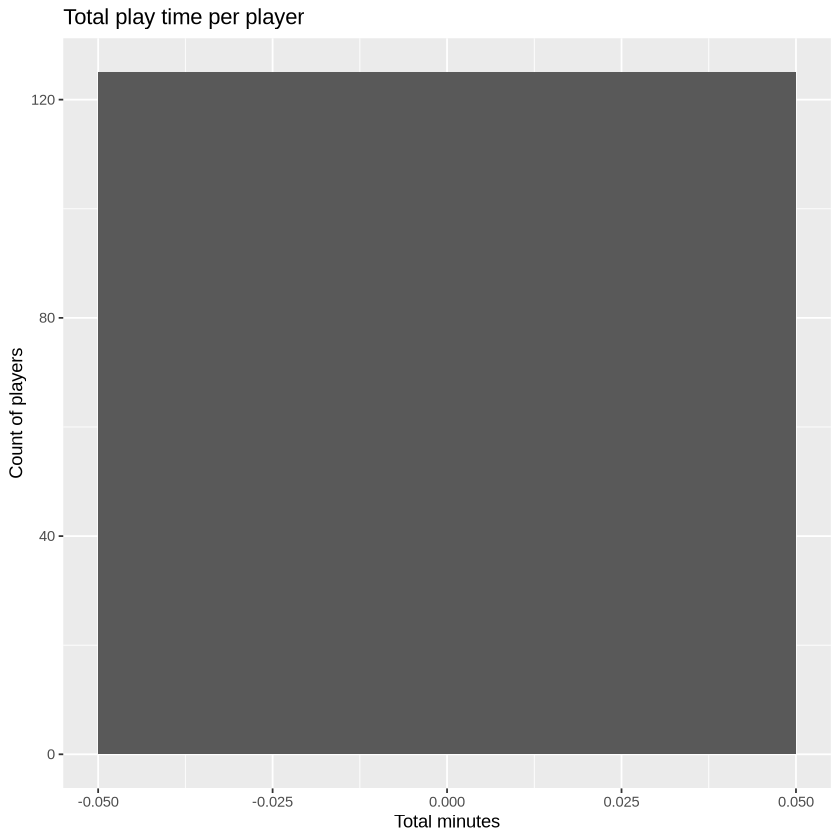

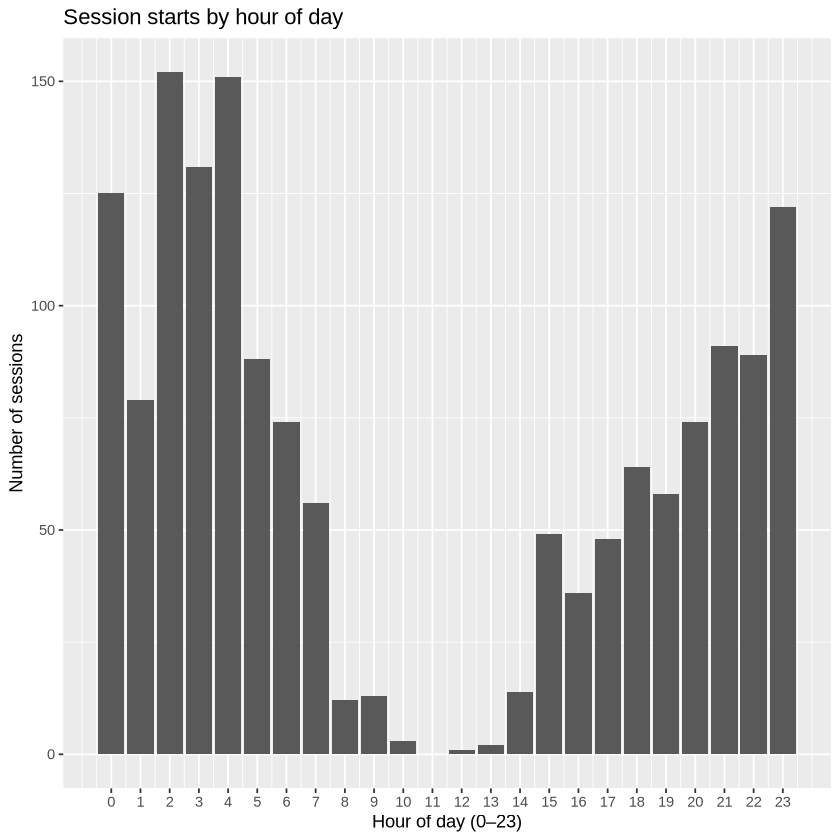

In [6]:
# ---- Plot 1: distribution of total minutes per player ----
p1 <- analysis_df |>
  ggplot(aes(x = total_minutes)) +
  geom_histogram(bins = 30) +
  labs(
    title = "Total play time per player",
    x     = "Total minutes",
    y     = "Count of players"
  )

p1

# ---- Plot 2: server demand by hour-of-day (session starts) ----
if (!is.na(start_col) && start_col %in% names(sessions2)) {
  p2 <- sessions2 |>
    mutate(hour = lubridate::hour(.data[[start_col]])) |>
    count(hour) |>
    ggplot(aes(x = hour, y = n)) +
    geom_col() +
    scale_x_continuous(breaks = 0:23) +
    labs(
      title = "Session starts by hour of day",
      x     = "Hour of day (0–23)",
      y     = "Number of sessions"
    )
  p2
} else {
  message("Start-time column not found; skipping Plot 2.")
}

## (3) Exploratory data analysis — quick insights

- **Total minutes per player** is strongly right-skewed (Plot 1): most players contribute a small number of minutes, while a small group contributes a lot. This supports the idea of “heavy contributors” that are interesting for recruitment.
- When a start-time column is available, **session starts by hour** show clear peaks (Plot 2). These peaks suggest time windows when the server is busiest, which matters for server capacity and experiment scheduling.
- My minimal wrangling created four player-level features: `sessions`, `total_minutes`, `median_session`, and `unique_days`. These use the standard `group_by()` + `summarise()` patterns from the DSCI 100 textbook.
- I have not removed outliers or engineered advanced features yet; extreme values or missing timestamps will be handled in the full group project (e.g., capping impossible durations, checking for logging errors).

## (2) Questions

**Broad question:** Which kinds of players contribute the most data to the Minecraft server?

**Specific predictive question:** Can we predict a player’s **total contributed minutes** from player attributes (from `players.csv`) and simple early behaviour summaries (from `sessions.csv`)?

**Rationale:** If we can identify likely heavy contributors early, the research group can target recruitment and incentives more efficiently and collect richer data with fewer players.

## (4) Methods & plan (no modelling yet)

**Planned methods**

- **Main model:** K-nearest neighbours (K-NN) regression  
- **Baseline:** Multiple linear regression  

K-NN can flexibly capture non-linear relationships between early behaviour (e.g., number of sessions, median session length) and `total_minutes`. Linear regression provides an interpretable baseline using ideas from the course text (estimate coefficients, inspect residuals, etc.).

**Data set for modelling**

- **Response:** `total_minutes` per player.  
- **Predictors:** demographic variables from `players.csv` plus simple aggregates from `sessions.csv` (`sessions`, `median_session`, `unique_days`, and possibly transformed `played_hours`).

**Analysis plan**

1. Filter obviously impossible durations (e.g., negative or extremely long sessions) and consider transforming `total_minutes` with `log1p` if skew is extreme.  
2. Split data: 80% training, 20% test; do all tuning using only the training set.  
3. Scale numeric predictors for K-NN.  
4. Use 5-fold cross-validation on the training set to choose K for K-NN and to compare with linear regression (RMSE and MAE).  
5. Fit the chosen model on the full training data and report test RMSE, MAE, and example predictions.

## (5) GitHub & reproducibility

Repo: https://github.com/mhfahad-git/DSCI-100-Individual-Part-Grooup-Project-

This notebook runs top-to-bottom using only `tidyverse`, `janitor`, `lubridate`, and `knitr`. I keep file paths relative (`players.csv`, `sessions.csv`) so that others can clone the repo and re-run the report. I made ≥5 commits with descriptive messages (e.g., “load + clean data”, “add variable overview”, “add wrangling and plots”, “write methods plan”), giving a reproducible record of my planning analysis.

*(If the automatic guesses ever fail, you can hard-code in the code cell:  
`pid_col   <- "hashed_email"`  
`start_col <- "start_time"`  
`end_col   <- "end_time"`.)*